# Import libraries

In [1]:
import numpy as np # calculations with arrays
import pandas as pd # user-friendly DataFrames for data representation
import sklearn # machine learning algorithms
from sklearn import ensemble, linear_model
from sklearn.metrics import log_loss
from sklearn import cross_validation
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
import xgboost as xgboost
import matplotlib.pyplot as plt # import plot functions
# necessary to plot in jupyter notebook:
%matplotlib inline
import seaborn as sns # make plots beautiful

/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Roman/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load data

In [2]:
train = pd.read_csv('train2.csv')
test = pd.read_csv('test2.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Data

In [3]:
train.head(3)

,year,day,team1,team2,score1,score2,target
0,2998,19,317,131,336,278,True
1,2998,28,61,29,301,259,True
2,2998,28,110,141,359,267,True


In [4]:
train.shape

(101609, 7)

In [5]:
test.head(3)

,Id,year,team1,team2
0,0,3021,363,161
1,1,3021,286,2
2,2,3020,232,52


In [6]:
sample_submission.head(3)

,Id,target
0,0,0.5
1,1,0.5
2,2,0.5


In [7]:
print 'train.shape = ', train.shape
print 'test.shape = ', test.shape
print 'sample_submission.shape = ', sample_submission.shape

train.shape =  (101609, 7)
test.shape =  (125207, 4)
sample_submission.shape =  (125207, 2)


# Work with categorical features

# Make dataset for cross-vallidation using One-Hot-Encoding

In [8]:
enc = OneHotEncoder(sparse=False)

In [9]:
train_team1 = pd.DataFrame(enc.fit_transform(train[['team1']]))

In [10]:
print 'train_team1.shape = ', train_team1.shape

train_team1.shape =  (101609, 353)


In [11]:
train_team2 = pd.DataFrame(enc.transform(train[['team2']]))

In [12]:
print 'train_team2.shape = ', train_team2.shape

train_team2.shape =  (101609, 353)


In [13]:
train_teams = pd.concat([train_team1, train_team2], axis=1)

In [14]:
print 'train_team1 + train_team2 = ', train_teams.shape

train_team1 + train_team2 =  (101609, 706)


In [15]:
test_team1 = pd.DataFrame(enc.transform(test[['team1']]))

In [16]:
print 'test_team1 = ', test_team1.shape

test_team1 =  (125207, 353)


In [17]:
test_team2 = pd.DataFrame(enc.transform(test[['team2']]))

In [18]:
print 'test_team2 = ', test_team2.shape

test_team2 =  (125207, 353)


In [19]:
test_teams = pd.concat([test_team1, test_team2], axis=1)

In [20]:
print 'test_teams.shape = ', test_teams.shape

test_teams.shape =  (125207, 706)


# Feature engenering

### Добавили среднее число очков: для команды team1 – среднее количество очков, набранных дома; для команды team2 – среднее количество очков, набранных в гостях

In [21]:
df_train = train
df_test = test

In [22]:
means_score = {}
for index_team in list(df_train.team1.unique()):
    df_for_team1 = df_train[df_train['team1'] == index_team]
    df_for_team2 = df_train[df_train['team2'] == index_team]
    means_score[index_team] = [int(df_for_team1.score1.mean()), int(df_for_team2.score2.mean())]
#print(means_score)
#for c in means_score:
#    print(means_score[c])

In [23]:
teams_not_train = []
for index_team in list(df_test.team1.unique()):
    if index_team not in list(df_train.team1.unique()):
        teams_not_train.append(index_team)
for index_team in list(df_test.team2.unique()):
    if index_team not in list(df_train.team1.unique()):
        teams_not_train.append(index_team)

In [24]:
for index_team in teams_not_train:
    means_score[index_team] = [df_train.score1.mean(), df_train.score2.mean()]

In [25]:
features_to_concat_train = []
for year, day, team1, team2, _, __, ___ in df_train.values:
    features_to_concat_train.append([means_score[team1][0], means_score[team2][1]])
features_to_concat_test = []
for Id, year, team1, team2 in df_test.values:
    features_to_concat_test.append([means_score[team1][0], means_score[team2][1]])

In [26]:
df_feature_to_concat_train = pd.DataFrame(data=features_to_concat_train, columns=['mean_home_score', 'mean_away_score'])

In [27]:
df_feature_to_concat_test = pd.DataFrame(data=features_to_concat_test, columns=['mean_home_score', 'mean_away_score'])

### Добавляем процент побед: для team1 – процент побед дома; для team2 – процент побед в гостях

In [28]:
percentage_wins = {}
for index_team in list(df_train.team1.unique()):
    df_for_team_home = df_train[df_train['team1'] == index_team]
    df_for_team_away = df_train[df_train['team2'] == index_team]
    percentage_wins[index_team] = [df_for_team_home.target.mean(), 1 - df_for_team_away.target.mean()]

In [29]:
for index_team in teams_not_train:
    percentage_wins[index_team] = [df_train.target.mean(), 1 - df_train.target.mean()]

In [30]:
percentage_of_wins_train = []
for year, day, team1, team2, _, __, ___ in df_train.values:
    percentage_of_wins_train.append([percentage_wins[team1][0], percentage_wins[team2][1]])
percentage_of_wins_test = []
for Id, year, team1, team2 in df_test.values:
    percentage_of_wins_test.append([percentage_wins[team1][0], percentage_wins[team2][1]])

In [31]:
df_percentage_of_wins_train = pd.DataFrame(data=percentage_of_wins_train, columns=['percentage_wins_home', 'percentage_wins_away'])

In [32]:
df_percentage_of_wins_test = pd.DataFrame(data=percentage_of_wins_test, columns=['percentage_wins_home', 'percentage_wins_away'])

   # Make X_train, X_test, y_train, y_test

### Делаем X_train

In [33]:
X_train_all_feat = pd.concat([train, df_feature_to_concat_train, df_percentage_of_wins_train], axis=1)

In [34]:
print 'X_train_all_feat.shape = ', X_train_all_feat.shape

X_train_all_feat.shape =  (101609, 11)


In [35]:
X_train_all_feat.head(2)

,year,day,team1,team2,score1,score2,target,mean_home_score,mean_away_score,percentage_wins_home,percentage_wins_away
0,2998,19,317,131,336,278,True,289,285,0.688073,0.640118
1,2998,28,61,29,301,259,True,273,276,0.503333,0.556962


In [36]:
y_train =  X_train_all_feat[['target']]

In [37]:
X_train_not_scaled = X_train_all_feat.drop(['day', 'team1', 'team2','score1', 'score2', 'target'], axis=1)

In [38]:
X_train_not_scaled.head(2)

,year,mean_home_score,mean_away_score,percentage_wins_home,percentage_wins_away
0,2998,289,285,0.688073,0.640118
1,2998,273,276,0.503333,0.556962


In [39]:
X_train_years = X_train_not_scaled.drop(['mean_home_score','mean_away_score','percentage_wins_home','percentage_wins_home','percentage_wins_away'], axis = 1)

In [40]:
X_train_years.head(2)

,year
0,2998
1,2998


In [41]:
print 'y_train.shape = ', y_train.shape

y_train.shape =  (101609, 1)


In [42]:
X_test_all_feat = pd.concat([test, df_feature_to_concat_test, df_percentage_of_wins_test], axis=1)

In [43]:
X_test_all_feat.shape

(125207, 8)

In [44]:
X_test_all_feat.head(2)

,Id,year,team1,team2,mean_home_score,mean_away_score,percentage_wins_home,percentage_wins_away
0,0,3021,363,161,250.0,278.0,0.428571,0.535826
1,1,3021,286,2,271.0,242.0,0.593567,0.394464


In [45]:
X_test_not_scaled = X_test_all_feat.drop(['Id', 'team1', 'team2'], axis=1)

In [46]:
X_test_not_scaled.head(2)

,year,mean_home_score,mean_away_score,percentage_wins_home,percentage_wins_away
0,3021,250.0,278.0,0.428571,0.535826
1,3021,271.0,242.0,0.593567,0.394464


In [64]:
X_train = pd.concat([X_train_years, train_teams], axis=1)

In [65]:
print 'X_train.shape = ', X_train.shape

X_train.shape =  (101609, 707)


In [66]:
X_train.head(2)

,year,0,1,2,3,4,5,6,7,8,...,343,344,345,346,347,348,349,350,351,352
0,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
test.head(2)

,Id,year,team1,team2
0,0,3021,363,161
1,1,3021,286,2


In [57]:
X_test_without_teams = test.drop(['team1','team2','Id'], axis=1)

In [68]:
X_test = pd.concat([X_test_without_teams, test_teams], axis=1)

In [70]:
print 'X_test.shape = ', X_test.shape

X_test.shape =  (125207, 707)


In [71]:
X_test_year.head(3)

,year,0,1,2,3,4,5,6,7,8,...,343,344,345,346,347,348,349,350,351,352
0,3021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
X_test.shape

(125207, 707)

In [72]:
X_train.head(3)

,year,0,1,2,3,4,5,6,7,8,...,343,344,345,346,347,348,349,350,351,352
0,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X_train.shape

(101609, 707)

# X_train, X_test

In [172]:
X_train.year.unique()

array([2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008,
       3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019])

In [173]:
## Дропаем год!
X_train_not_year = X_train.drop('year', axis=1)

In [174]:
75278. / X_train.shape[0]

0.7408595695263215

In [175]:
train_data = pd.DataFrame(X_train_not_year.values[:75278, :])

In [176]:
test_data = pd.DataFrame(X_train_not_year.values[75278:, :])

In [177]:
train_data.shape

(75278, 706)

In [178]:
test_data.shape

(26331, 706)

In [179]:
train_team2_not_year = pd.DataFrame(train_team2.values[:75278, :])

In [180]:
train_team1_not_year = pd.DataFrame(train_team1.values[:75278, :])

In [199]:
test_team2_not_year = pd.DataFrame(train_team2.values[75278:, :])

In [200]:
test_team1_not_year = pd.DataFrame(train_team1.values[75278:, :])

In [201]:
test_team2_not_year.shape

(26331, 353)

In [202]:
df_to_add_teams_train = pd.concat([train_team2_not_year, train_team1_not_year], axis=1)

In [203]:
df_to_add_teams_train.shape

(75278, 706)

In [204]:
df_to_add_teams_train.columns = [i for i in range(706)]

In [225]:
df_to_add_teams_test.columns =[i for i in range(706)]

In [206]:
df_to_add_teams_train.shape

(75278, 706)

In [207]:
df_to_add_teams_test = pd.concat([test_team2_not_year, test_team1_not_year], axis=1)

In [208]:
df_to_add_teams_test.shape

(26331, 706)

In [209]:
train_data.shape

(75278, 706)

In [210]:
train_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,696,697,698,699,700,701,702,703,704,705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
df_to_add_teams_train.shape

(75278, 706)

In [212]:
df_to_add_teams_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,696,697,698,699,700,701,702,703,704,705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
df_X_train = pd.concat([train_data, df_to_add_teams_train], axis=0)

In [214]:
df_X_train.shape

(150556, 706)

In [215]:
len(df_y_train)

150556

In [216]:
test_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,696,697,698,699,700,701,702,703,704,705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
df_to_add_teams_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,351,352
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [223]:
test_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,696,697,698,699,700,701,702,703,704,705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
df_to_add_teams_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,343,344,345,346,347,348,349,350,351,352
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_to_add_teams_test = 

In [226]:
df_X_test = pd.concat([test_data, df_to_add_teams_test], axis=0)

In [227]:
df_X_test.shape

(52662, 706)

In [228]:
df_X_train.shape

(150556, 706)

In [229]:
y_to_add = list(map(lambda x: 1-x, y_train.values.T[0]))[:75278]

In [230]:
y_tr = y_train.values.T[0][:75278]

In [231]:
df_y_train = list(y_tr)+list(y_to_add)

In [232]:
len(df_y_train)

150556

In [233]:
y_to_add_test = list(map(lambda x: 1-x, y_train.values.T[0]))[75278:]

In [234]:
len(y_to_add_test)

26331

In [235]:
df_X_test.shape

(52662, 706)

In [236]:
y_te = y_train.values.T[0][75278:]

In [237]:
df_y_test = list(y_te)+list(y_to_add_test)

In [238]:
len(df_y_test)

52662

In [241]:
df_X_train.shape

(150556, 706)

In [243]:
len(df_y_train)

150556

In [244]:
df_X_test.shape

(52662, 706)

In [246]:
len(df_y_test)

52662

# df_X_train - расширенная train.csv, y_train_arr - ответы под df_X_train

In [309]:
param = {'C': np.linspace(0.2, 1.6, 10)}

In [322]:
lin_cl = linear_model.LogisticRegression(C=0.1)

In [323]:
lin_cl.fit(df_X_train.values, np.array(df_y_train.T)[0])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [324]:
log_loss(df_y_test, lin_cl.predict_proba(df_X_test)[:,1])

0.6328927305589287

In [330]:
xgb = xgboost.XGBClassifier(n_estimators=150)

In [331]:
xgb.fit(df_X_train.values, np.array(df_y_train.T)[0])

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=150,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1)

In [332]:
log_loss(df_y_test, xgb.predict_proba(df_X_test)[:,1])

0.67831329690948727

# Вывод ответа

In [90]:
ss = sample_submission.copy()
ss.target = y_pred
ss.to_csv('ans.csv', index=False)

# Попытка n2

In [178]:
train.day.unique()

array([ 19,  28,  30,  31,  33,  35,  37,  38,  40,  42,  44,  46,  47,
        49,  51,  53,  54,  56,  58,  60,  61,  63,  65,  67,  69,  70,
        72,  74,  76,  77,  79,  81,  83,  84,  86,  93,  95,  97,  99,
       100, 104, 106, 107, 109, 111, 113, 115, 116, 118, 120, 122, 123,
       125, 127, 129, 130, 132, 134, 136, 138, 139, 141, 143, 145, 146,
       148, 150, 152, 153, 155, 157, 159, 161, 162, 164, 166, 168, 169,
       171, 173, 175, 177, 178, 180, 182, 184, 185, 187, 189, 191, 192,
       194, 196, 198, 200, 201, 203, 205, 207, 208, 210, 212, 214, 215,
       217, 219, 221, 223, 224, 226, 228, 230, 231, 233,  88,  90, 102,
        92,  26,  21,  23,  24,  17,  14,  15,   0,   1,   3,   5,   7,
         8,  10,  12])

In [179]:
years = train.year.unique()

In [171]:
df_3003 = train[ train[y]]

NameError: name 'y' is not defined

In [ ]:
df_years = []
for year in years:
    df_year = train[ train['year'] == year]
    print df_year.day.unique()
    print '\n'

In [162]:
type(df_years[0])

numpy.ndarray

In [166]:

for i in range(50):
    for j in range(len(df_years)):
        if df_years[j] <0:
                   break
        else:
            tmp = i
    continue
                   

AttributeError: 'list' object has no attribute 'find'

In [ ]:
cnt_games_233 = []
for i in years:
    df_year = train[train['year']==i]
    print df_year.head(2)
    cnt_games_233.append(df_year[df_year['day']==233].shape[0])
    print df_year[df_year['day']==233]

In [182]:
print cnt_games_233

[10, 8, 7, 9, 5, 5, 5, 5, 4, 4, 4, 4, 5, 6, 5, 5, 5, 5, 4, 4, 4, 4]


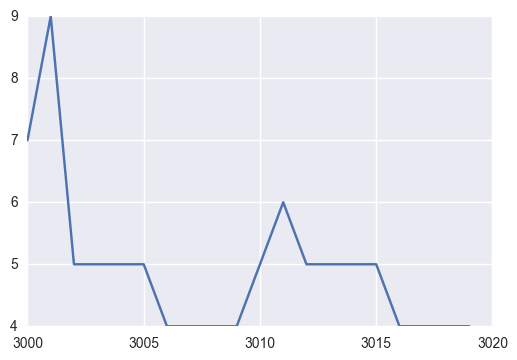

In [193]:
plt.plot(years[2:], cnt_games_233[2:])

In [194]:
train.team1.unique()

array([317,  61, 110, 352, 229, 164, 184, 245, 300,  10,  39, 205,  47,
       180,  53,  63,  82, 265,  70, 150, 188, 161, 241, 273, 232, 201,
       207, 146, 206, 234, 260, 250, 283, 302, 291, 272, 351, 159, 295,
       308,  48,  59,   4,  14,  65, 310, 287,  38,  78,  50,  96, 104,
       198, 337, 134, 320, 327, 157, 163, 168, 192, 204, 217, 220, 237,
       248, 268, 285, 249, 126, 326, 331, 129, 334,  92, 347, 322, 158,
       353, 160, 361, 135, 336,  54,  69,  16,  43,  51,  32, 254,  60,
        68,  73, 191,  87, 132,  90,  91,  11, 202,  80, 177, 179,  45,
       325, 208, 128, 274, 303, 211, 323, 299, 356, 344, 355, 269,  29,
       259,  13, 258,  35,  31,  33, 329,  64, 133, 124, 139, 173, 142,
       178,  17, 185, 210, 226, 228, 238, 209, 239, 100, 278, 293, 247,
       321,  74, 187, 122, 236, 244, 256, 275, 312, 196,  56, 172, 288,
        85,  26, 101, 111, 118, 174, 182, 339,  20, 316, 262, 328, 338,
       340, 190,  19, 218,  30, 175,  55,  81,  83, 102, 116, 12

In [195]:
df_year = train[ train['year'] == 2998]

In [196]:
scores = []
team = 174
days = []

In [203]:
home_games = np.array(df_year[df_year['team1'] == team])

In [204]:
for i in range(home_games.shape[0]):
    scores.append(home_games.[i])
    days.append(home_games.score1[i])

AttributeError: 'numpy.ndarray' object has no attribute 'score1'

In [207]:
print list(sorted(train.score1.unique()))

[81, 85, 89, 92, 96, 100, 104, 108, 112, 116, 119, 123, 127, 131, 135, 139, 143, 147, 150, 154, 158, 162, 166, 170, 174, 178, 181, 185, 189, 193, 197, 201, 205, 208, 212, 216, 220, 224, 228, 232, 236, 239, 243, 247, 251, 255, 259, 263, 267, 270, 274, 278, 282, 286, 290, 294, 297, 301, 305, 309, 313, 317, 321, 325, 328, 332, 336, 340, 344, 348, 352, 356, 359, 363, 367, 371, 375, 379, 383, 387, 390, 394, 398, 402, 406, 410, 414, 417, 421, 425, 429, 433, 437, 441, 445, 448, 452, 456, 460, 464, 468, 472, 476, 479, 483, 487, 491, 495, 499, 503, 506, 510, 514, 526, 530, 534, 541, 545, 549, 553, 565, 572, 592, 599, 603]


In [208]:
print list(sorted(train.score2.unique()))

[77, 81, 85, 92, 96, 100, 104, 108, 112, 116, 119, 123, 127, 131, 135, 139, 143, 147, 150, 154, 158, 162, 166, 170, 174, 178, 181, 185, 189, 193, 197, 201, 205, 208, 212, 216, 220, 224, 228, 232, 236, 239, 243, 247, 251, 255, 259, 263, 267, 270, 274, 278, 282, 286, 290, 294, 297, 301, 305, 309, 313, 317, 321, 325, 328, 332, 336, 340, 344, 348, 352, 356, 359, 363, 367, 371, 375, 379, 383, 387, 390, 394, 398, 402, 406, 410, 414, 417, 421, 425, 429, 433, 437, 441, 445, 448, 452, 456, 460, 464, 468, 472, 476, 479, 483, 487, 491, 495, 499, 503, 506, 510, 514, 518, 537, 541, 549, 553, 557, 580, 615]


In [209]:
years

array([2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008,
       3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019])

In [ ]:
for y in years:
    df_year = train[train['year']==y]
    print len(df_year.team1.unique()), len(df_year.day.unique())

In [219]:
train.head(2)

,year,day,team1,team2,score1,score2,target
0,2998,19,317,131,336,278,True
1,2998,28,61,29,301,259,True


In [240]:
X = train[['year','day']]

In [243]:
train_teams.shape

(101609, 706)

In [ ]:
X.sh

In [279]:
X = pd.concat([train_teams, pd.DataFrame(train_teams.index)], axis=1)

In [280]:
X.shape

(101609, 707)

In [281]:
X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,344,345,346,347,348,349,350,351,352,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [282]:
y = train[['target']] 

In [283]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X,y, test_size=0.4)

In [284]:
train_X.shape

(60965, 707)

In [285]:
train_y.shape

(60965, 1)

In [286]:
lg = linear_model.LogisticRegression(C=0.8)

In [287]:
lg.fit(train_X, train_y)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
lg.coef_

In [289]:
log_loss(test_y, lg.predict_proba(test_X)[:,1])

0.6144729902067928

In [291]:
train_X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,344,345,346,347,348,349,350,351,352,0
74701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74701
61808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61808


# Последний шанс

In [348]:
train.head(5)

,year,day,team1,team2,score1,score2,target
0,2998,19,317,131,336,278,True
1,2998,28,61,29,301,259,True
2,2998,28,110,141,359,267,True
3,2998,28,352,146,309,410,False
4,2998,28,229,91,332,220,True


In [349]:
target = train['score1'] - train['score2']

In [350]:
target.head(5)

0     58
1     42
2     92
3   -101
4    112
dtype: int64

In [351]:
X_train = pd.concat([train[['year']], train_teams], axis=1)

In [352]:
X_train.head(2)

,year,0,1,2,3,4,5,6,7,8,...,343,344,345,346,347,348,349,350,351,352
0,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [353]:
X_train.shape

(101609, 707)

In [354]:
train_data, test_data, train_target, test_target = cross_validation.train_test_split(X_train, target, test_size=0.3)

In [355]:
train_data.head(2)

,year,0,1,2,3,4,5,6,7,8,...,343,344,345,346,347,348,349,350,351,352
37773,3007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73832,3014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [356]:
lin_cl = linear_model.LinearRegression()

In [357]:
lin_cl.fit(train_data, np.array(train_target))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [358]:
y_pred = lin_cl.predict(test_data)

In [359]:
print sklearn.metrics.mean_absolute_error(y_pred, test_target)

39.7233421051


In [360]:
 list(y_pred[:20])

[-7.8052978515625,
 -18.8409423828125,
 4.44659423828125,
 -21.564208984375,
 14.7408447265625,
 41.83349609375,
 -22.947509765625,
 0.0020751953125,
 23.463623046875,
 13.5787353515625,
 37.652587890625,
 17.95257568359375,
 -21.2742919921875,
 14.4525146484375,
 -0.57708740234375,
 12.8328857421875,
 -2.18585205078125,
 21.03216552734375,
 98.2603759765625,
 45.5989990234375]

In [368]:
an = np.array(test_target)

In [370]:
for i in range(len(y_pred)):
    if y_pred[i]>0:
        y_pred[i]=1
    else:
        y_pred[i]=0
    if an[i]>0:
        an[i]=1
    else:
        an[i]=0

In [373]:
sklearn.metrics.log_loss(an, y_pred)

11.874503433016764

### Нейронная сеть

In [479]:
from pybrain.datasets import ClassificationDataSet # Структура данных pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError

In [480]:
# Определение основных констант
HIDDEN_NEURONS_NUM = 100 # Количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # Максимальное число итераций алгоритма оптимизации параметров сети

In [481]:
X_train.head(2)

,year,mean_home_score,mean_away_score,percentage_wins_home,percentage_wins_away,0,1,2,3,4,...,343,344,345,346,347,348,349,350,351,352
0,-1.752835,1.411135,1.134001,1.573942,1.261859,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.752835,0.236316,0.468392,0.019886,0.518128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [482]:
X_train.shape

(101609, 711)

In [483]:
X_test.head(2)

,year,mean_home_score,mean_away_score,percentage_wins_home,percentage_wins_away,0,1,2,3,4,...,343,344,345,346,347,348,349,350,351,352
0,1.873146,-1.452486,0.616305,-0.609021,0.329087,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.873146,0.089464,-2.046131,0.778944,-0.935227,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [484]:
y_train.shape

(101609, 1)

In [485]:
X_test.shape

(125207, 711)

In [486]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_train, y_train)
train_labels = train_labels.values
test_labels = test_labels.values

In [487]:
ds_train = ClassificationDataSet(np.shape(X_train)[1], nb_classes=len(np.unique(y_train)))
ds_train.setField('input', train_data)
ds_train.setField('target', train_labels[:, np.newaxis])
ds_test = ClassificationDataSet(np.shape(X_test)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', test_data)
ds_test.setField('target', test_labels[:, np.newaxis])

In [488]:
np.random.seed(0)  # Зафиксируем seed для получения воспроизводимого результата

In [489]:
net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer)

In [490]:
init_params = np.random.random((len(net.params))) 

In [491]:
net._setParameters(init_params)

In [493]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np

In [ ]:
random.seed(0)
# Модуль настройки параметров pybrain использует модуль random; зафиксируем seed для получения воспроизводимого результата
trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')